<a href="https://colab.research.google.com/github/aarakova/AD/blob/stat6/%D0%A1%D0%A2%D0%90%D0%A2%D0%98%D0%A1%D0%A2%D0%98%D0%9A%D0%90_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

image.png

# Подготовка данных




In [2]:
import numpy as np
import pandas as pd
from numpy.fft import fft
from scipy.stats import ttest_ind, wilcoxon, linregress, norm
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import breaks_cusumolsresid
from scipy.stats import t

# Данные
data = {
    'Year': [2014, 2015, 2016],
    'Jan': [8.4, 8.4, 7.3],
    'Feb': [8.1, 8.2, 7.1],
    'Mar': [8.5, 6.7, 7.6],
    'Apr': [7.6, 7.5, 7.6],
    'May': [9.2, 8.1, 8.5],
    'Jun': [10.2, 10.0, 9.8],
    'Jul': [11.3, 11.9, 10.9],
    'Aug': [11.9, 11.9, 11.7],
    'Sep': [12.1, 11.7, 11.7],
    'Okt': [10.6, 10.6, 10.4],
    'Now': [9.7, 9.0, 9.7],
    'Des': [9.3, 7.9, 8.3]
}
df = pd.DataFrame(data)

# Преобразование в временной ряд, где столбцы представляют месяцы, а строки - годы
df_melted = df.melt(id_vars='Year', var_name='Month', value_name='Temperature')
y = df_melted['Temperature'].values

# Анализ тренда

**Проверка наличия трендовой составляющей**
- Метод сравнения средних

Этот метод предполагает сравнение средних значений двух частей временного ряда (первой и второй половины). Если средние отличаются статистически значимо, это указывает на наличие тренда.

In [3]:
# Разделение временного ряда на две части
half = len(y) // 2
first_half = y[:half]
second_half = y[half:]

# Метод сравнения средних
t_stat, p_value = ttest_ind(first_half, second_half)
print(f"t-статистика: {t_stat}, p-значение: {p_value}")
if p_value < 0.05:
    print("Гипотеза о равенстве средних отвергается. Тренд, вероятно, есть.")
else:
    print("Гипотеза о равенстве средних не отвергается. Тренд не обнаружен.")

t-статистика: -5.934356680054569, p-значение: 1.0478947090867778e-06
Гипотеза о равенстве средних отвергается. Тренд, вероятно, есть.


- Метод серий

Метод серий используется для проверки случайности ряда. Если ряды значений (вверх или вниз) нарушают случайность, это может быть индикатором тренда.

In [4]:
# Метод серий
cusum_test = breaks_cusumolsresid(y, ddof=1)

# Извлекаем p-value
p_value_series = cusum_test[1]

print(f"p-значение метода серий: {p_value_series}")
if p_value_series < 0.05:
    print("Ряд имеет тренд.")
else:
    print("Ряд не имеет тренда.")

p-значение метода серий: 6.032316916554645e-30
Ряд имеет тренд.


- Метод медиан

Проверяет случайность отклонений относительно медианы

In [5]:
median = np.median(y)
deviations = y - median

# Проверка отклонений от медианы
stat, p_value_median = wilcoxon(deviations)
print(f"p-значение метода медиан: {p_value_median}")
if p_value_median < 0.05:
    print("Ряд имеет тренд относительно медианы.")
else:
    print("Тренд относительно медианы не обнаружен.")

p-значение метода медиан: 0.5920094623870682
Тренд относительно медианы не обнаружен.


- Z-критерий

Для оценки отклонений можно применить Z-критерий, основанный на стандартном отклонении.

In [6]:
z_scores = (y - np.mean(y)) / np.std(y)
# print(f"Z-оценки:\n{z_scores}")

# Проверяем на отклонения
threshold = 3
if np.any(np.abs(z_scores) > threshold):
    print("Обнаружены значительные отклонения, возможен тренд.")
else:
    print("Значительных отклонений не обнаружено.")

Значительных отклонений не обнаружено.


**Проверка ряда на наличие аномалий**
- IQR межквартильный размах

Аномалиями считаются точки, выходящие за пределы Q1-1.5IQR или Q3+1.5IQR.



In [7]:
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

anomalies = y[(y < lower_bound) | (y > upper_bound)]
print(f"Аномалии: {anomalies}")

Аномалии: []


**Обоснование выбора критериев:**

- Метод сравнения средних: легко интерпретируется, подходит для проверки изменений между частями временного ряда.

- Метод серий: подходит для проверки случайности ряда.
Метод медиан: Помогает выявить устойчивые отклонения относительно медианы.

- Z-критерий: используется для оценки значительности отклонений.

- IQR: надежен для обнаружения выбросов в данных.


**Анализ выбросов**

Анализ выбросов проводится для выявления аномальных значений, которые могут значительно отклоняться от общего тренда данных. Такие выбросы могут быть вызваны ошибками измерений, редкими событиями или другими факторами. Проведение этого анализа помогает улучшить точность дальнейших расчётов, таких как тренды и автокорреляции, поскольку выбросы могут искажать результаты.

In [8]:
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = y[(y < lower_bound) | (y > upper_bound)]
print(f"Выбросы в данных: {outliers}")
if len(outliers) > 0:
    print("Выбросы могут искажать тренды. Нужно проверить их природу.")
else:
    print("Выбросы отсутствуют, данные выглядят корректно.")

Выбросы в данных: []
Выбросы отсутствуют, данные выглядят корректно.


Анализ выбросов показал, что выбросы в данных отсутствуют. Это свидетельствует о том, что значения температуры поверхности океана находятся в пределах ожидаемых норм и не содержат аномалий, которые могли бы исказить расчёт трендов или автокорреляции. Данные выглядят корректно для дальнейшего анализа и использования в построении моделей.

**Рассчет трендовой составляющей и коэффициента корреляции:**

In [9]:
# Расчет уравнения тренда
x = np.arange(len(y))
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(f"Уравнение тренда: T(t) = {intercept:.2f} + {slope:.2f}t")
print(f"Коэффициент корреляции: {r_value:.2f}")

Уравнение тренда: T(t) = 7.98 + 0.08t
Коэффициент корреляции: 0.53


**Оценка значимости коэффициента корреляции:**

Выдвигается нулевая гипотеза H0: r = 0, для проверки которой рассчитывается критерий Стьюдента.

По статистическим таблицам определяем tкр - критерий Стьюдента при заданном уровне значимости (5%) и числе степеней свободы v=(n-1).

Если |t*|>tкр, то нулевая гипотеза отвергается. Это означает, что тренд неслучайным образом отличается от нуля и вносит определенный вклад в формирование изменчивости исходного ряда.

In [10]:
sigma_r = std_err / np.sqrt(len(y))
t_value = r_value / sigma_r
degrees_of_freedom = len(y) - 2
critical_value = norm.ppf(0.975)
print(f"t*: {t_value}, критическое значение: {critical_value}")

if abs(t_value) > critical_value:
    print("Гипотеза H0 (r = 0) отвергается.")
else:
    print("Гипотеза H0 (r = 0) принимается.")

t*: 139.45544171041925, критическое значение: 1.959963984540054
Гипотеза H0 (r = 0) отвергается.


# Построение графиков

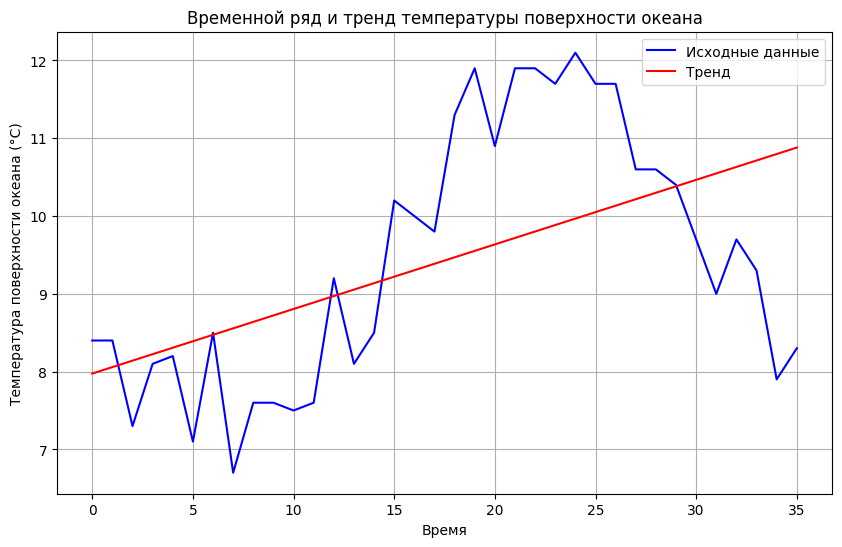

In [11]:
import matplotlib.pyplot as plt

# График временного ряда и тренда
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Исходные данные', color='blue')
plt.plot(x, intercept + slope * x, label='Тренд', color='red')
plt.xlabel('Время')
plt.ylabel('Температура поверхности океана (°C)')
plt.title('Временной ряд и тренд температуры поверхности океана')
plt.legend()
plt.grid(True)
plt.show()

**Анализ графика**
1. Исходные данные:
   - Голубая линия отражает временной ряд температуры поверхности океана.
   - Видна высокая изменчивость данных, которая может быть обусловлена сезонными колебаниями или другими природными факторами.

2. Тренд:
   - Красная линия — линейная аппроксимация временного ряда.
   - Наклон тренда положительный, что говорит о росте температуры поверхности океана с течением времени.

3. Характер тренда:
   - Тренд линейный и постепенно восходящий.
   - Рост температуры не резкий, свидетельствует о долгосрочной тенденции к повышению средней температуры поверхности океана.

# Автокорреляция

Вычисление коэффициентов автокорреляции для каждого из сдвигов.

In [12]:
# Вычисление коэффициентов автокорреляции
lag_count = 36  # Число сдвигов, 12*3
acf_values = acf(y, nlags=lag_count, fft=True)

# Вывод коэффициентов автокорреляции
print("Коэффициенты автокорреляции:")
for lag, value in enumerate(acf_values):
    print(f"Сдвиг {lag}: {value:.3f}")

Коэффициенты автокорреляции:
Сдвиг 0: 1.000
Сдвиг 1: 0.852
Сдвиг 2: 0.800
Сдвиг 3: 0.769
Сдвиг 4: 0.638
Сдвиг 5: 0.491
Сдвиг 6: 0.392
Сдвиг 7: 0.252
Сдвиг 8: 0.078
Сдвиг 9: -0.035
Сдвиг 10: -0.171
Сдвиг 11: -0.269
Сдвиг 12: -0.359
Сдвиг 13: -0.414
Сдвиг 14: -0.450
Сдвиг 15: -0.483
Сдвиг 16: -0.498
Сдвиг 17: -0.452
Сдвиг 18: -0.413
Сдвиг 19: -0.404
Сдвиг 20: -0.306
Сдвиг 21: -0.259
Сдвиг 22: -0.220
Сдвиг 23: -0.159
Сдвиг 24: -0.100
Сдвиг 25: -0.060
Сдвиг 26: -0.018
Сдвиг 27: 0.015
Сдвиг 28: 0.024
Сдвиг 29: 0.042
Сдвиг 30: 0.045
Сдвиг 31: 0.040
Сдвиг 32: 0.048
Сдвиг 33: 0.043
Сдвиг 34: 0.029
Сдвиг 35: 0.012


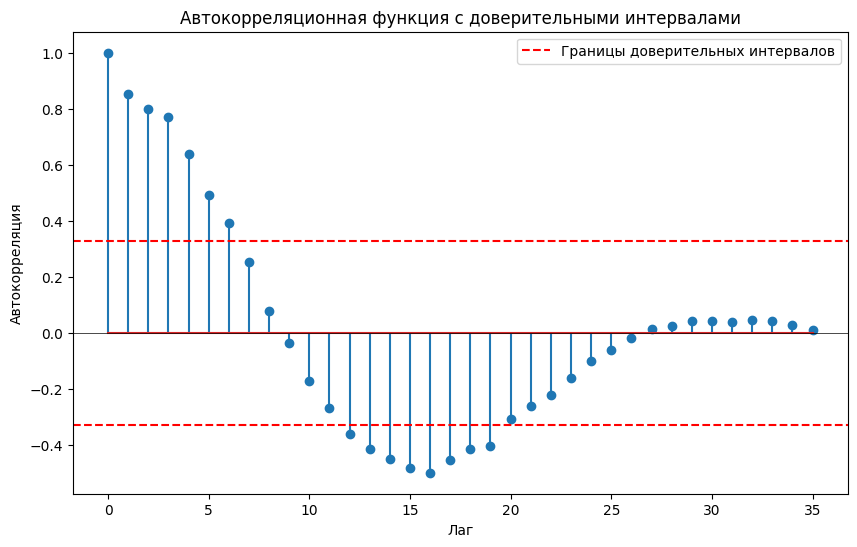

In [13]:
# Построение графика автокорреляции
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)
n = len(y)
conf_interval = z_score / np.sqrt(n)

plt.figure(figsize=(10, 6))
plt.stem(range(len(acf_values)), acf_values)
plt.axhline(y=conf_interval, linestyle='--', color='red', label='Границы доверительных интервалов')
plt.axhline(y=-conf_interval, linestyle='--', color='red')
plt.axhline(y=0, color='black', linewidth=0.5)
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.title('Автокорреляционная функция с доверительными интервалами')
plt.legend()
plt.show()

In [14]:
significant_lags = [lag for lag, value in enumerate(acf_values) if abs(value) > conf_interval]
print(f"Значимые лаги: {significant_lags}")

Значимые лаги: [0, 1, 2, 3, 4, 5, 6, 12, 13, 14, 15, 16, 17, 18, 19]


**Циклическая составляющая:**
- На графике наблюдается волнообразное поведение коэффициентов автокорреляции, что указывает на наличие цикличности во временном ряду.
- Однако периодичность не чётко выраженная. Например, интервал между максимумами (или минимумами) автокорреляции не соответствует чётко одному и тому же значению лага, что может указывать на сложные закономерности или комбинацию нескольких циклов.

**Вывод об отсутствии белого шума:**
- Если бы временной ряд был случайным процессом («белый шум»), то автокорреляция для всех лагов, кроме нулевого, была бы близка к нулю. Здесь же наблюдаются отклонения от нуля, что исключает белый шум.

Оценка значимости коэффициентов автокорреляции r(τ) на основе нулевой гипотезы Н0: r(τ )=0 при τ≠0.

In [ ]:
def calculate_sigma_r_tau(n, tau):
    return 1 / np.sqrt(n - 1 - tau)

# Уровень значимости
alpha = 0.05
# Критический критерий Стьюдента
t_critical = t.ppf(1 - alpha / 2, df=n - 2)

# Значения для первого и последнего сдвигов
first_lag = 1
last_lag = len(acf_values) - 1

# Расчёт значений σ_r_tau
sigma_r_first = calculate_sigma_r_tau(n, first_lag)
sigma_r_last = calculate_sigma_r_tau(n, last_lag)

# Проверка значимости
is_significant_first = abs(acf_values[first_lag]) > t_critical * sigma_r_first
is_significant_last = abs(acf_values[last_lag]) > t_critical * sigma_r_last

# Вывод результатов
print(f"Коэффициент автокорреляции для первого лага (τ={first_lag}): {acf_values[first_lag]:.3f}")
print(f"σ_r_τ для первого лага: {sigma_r_first:.3f}")
print(f"Критическое значение t_a: {t_critical:.3f}")
print(f"Значимость для первого лага: {'значим' if is_significant_first else 'незначим'}\n")

print(f"Коэффициент автокорреляции для последнего лага (τ={last_lag}): {acf_values[last_lag]:.3f}")
print(f"σ_r_τ для последнего лага: {sigma_r_last:.3f}")
print(f"Значимость для последнего лага: {'значим' if is_significant_last else 'незначим'}")

Коэффициент автокорреляции для первого лага (τ=1): 0.852
σ_r_τ для первого лага: 0.171
Критическое значение t_a: 2.032
Значимость для первого лага: значим

Коэффициент автокорреляции для последнего лага (τ=35): 0.012
σ_r_τ для последнего лага: inf
Значимость для последнего лага: незначим


<ipython-input-17-96507830527a>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 / np.sqrt(n - 1 - tau)


**Вывод**:
- Коэффициент автокорреляции для первого лага значим, что указывает на сильную связь между соседними наблюдениями.
- Коэффициент автокорреляции для последнего лага незначим, что указывает на отсутствие значимой связи для этого лага.

# Сезонная составляющая

Сезонная составляющая через ряд Фурье:

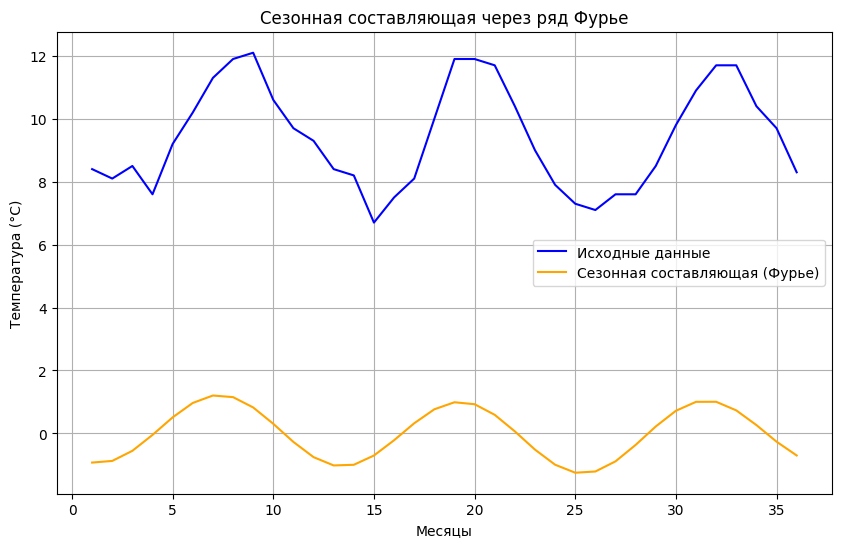

Аналитическая форма:
Гармоника 1: 0.16 * cos(2π * 0.03 * t + -1.04)
Гармоника 2: 0.03 * cos(2π * 0.06 * t + -0.07)
Гармоника 3: 1.09 * cos(2π * 0.08 * t + 2.42)


In [19]:
# Данные
months = np.arange(1, 37)  # Всего 36 месяцев
temperatures = [8.4, 8.1, 8.5, 7.6, 9.2, 10.2, 11.3, 11.9, 12.1, 10.6, 9.7, 9.3,
                8.4, 8.2, 6.7, 7.5, 8.1, 10.0, 11.9, 11.9, 11.7, 10.4, 9.0, 7.9,
                7.3, 7.1, 7.6, 7.6, 8.5, 9.8, 10.9, 11.7, 11.7, 10.4, 9.7, 8.3]  # Временной ряд

# Преобразование Фурье
fft_values = np.fft.fft(temperatures)
frequencies = np.fft.fftfreq(len(temperatures), d=1)  # Частоты

# Выделение реальных частей
amplitudes = np.abs(fft_values) / len(temperatures)  # Амплитуды гармоник
phases = np.angle(fft_values)  # Фазы гармоник

# Реконструкция сезонной составляющей с использованием первых 3 гармоник
reconstructed = np.zeros_like(temperatures, dtype=float)
for k in range(1, 4):  # Первые 3 гармоники
    reconstructed += amplitudes[k] * np.cos(2 * np.pi * frequencies[k] * months + phases[k])

# График
plt.figure(figsize=(10, 6))
plt.plot(months, temperatures, label='Исходные данные', color='blue')
plt.plot(months, reconstructed, label='Сезонная составляющая (Фурье)', color='orange')
plt.xlabel('Месяцы')
plt.ylabel('Температура (°C)')
plt.title('Сезонная составляющая через ряд Фурье')
plt.legend()
plt.grid()
plt.show()

# Аналитическое представление
print("Аналитическая форма:")
for k in range(1, 4):
    print(f"Гармоника {k}: {amplitudes[k]:.2f} * cos(2π * {frequencies[k]:.2f} * t + {phases[k]:.2f})")


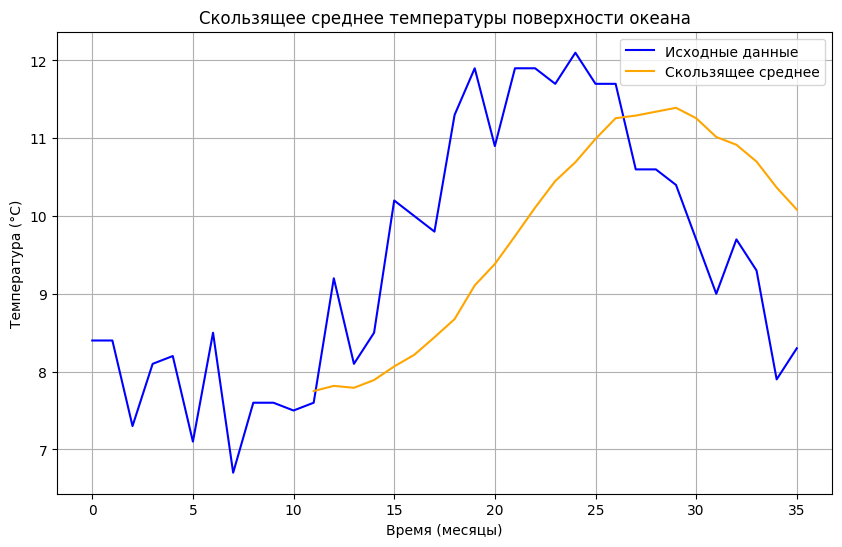

In [ ]:
# Скользящее среднее
plt.figure(figsize=(10, 6))
rolling_mean = pd.Series(y).rolling(window=12).mean()
plt.plot(y, label='Исходные данные', color='blue')
plt.plot(rolling_mean, label='Скользящее среднее', color='orange')
plt.xlabel('Время (месяцы)')
plt.ylabel('Температура (°C)')
plt.title('Скользящее среднее температуры поверхности океана')
plt.legend()
plt.grid(True)
plt.show()

На основе представленного графика скользящего среднего и временного ряда можно сделать следующие выводы о типе случайного процесса:

1. **Автокорреляция**:
   - Из предыдущего анализа автокорреляционной функции видно, что имеются значимые автокорреляции на малых лагах.
   - Это исключает «белый шум», поскольку «белый шум» характеризуется отсутствием значимых автокорреляций, кроме лага 0.

2. **Характер процесса**:
   - График временного ряда и скользящего среднего показывает **плавные изменения значений**, без резких скачков.
   - Это соответствует свойствам **красного шума**, который характеризуется сильной корреляцией на малых лагах и затуханием на больших.

3. **Цикличность**:
   - На графике скользящего среднего присутствуют плавные волнообразные колебания, что может указывать на слабовыраженную **цикличность**, особенно в среднем интервале данных (10–30).

**Вывод:** Процесс имеет свойства **красного шума** с возможными элементами цикличности. Это означает, что временной ряд демонстрирует сильную автокорреляцию на малых лагах и постепенное затухание взаимосвязи на более отдалённых временных интервалах. Возможная цикличность требует дополнительного анализа, например, с использованием спектрального анализа.

Сезонное уравнение:

In [ ]:
# Делим на сезоны
seasons = {
    'Winter': ['Des', 'Jan', 'Feb'],
    'Spring': ['Mar', 'Apr', 'May'],
    'Summer': ['Jun', 'Jul', 'Aug'],
    'Autumn': ['Sep', 'Okt', 'Now']
}

# Рассчитываем индексы сезонности для каждого сезона
def calculate_seasonal_indices(data, seasons):
    seasonal_indices = {season: [] for season in seasons.keys()}

    for season, months in seasons.items():
        values = []
        for month in months:
            values.extend(data[month])  # Собираем все значения за все годы для текущего сезона
        seasonal_indices[season] = np.mean(values)

    return seasonal_indices

# Рассчитываем
seasonal_indices = calculate_seasonal_indices(data, seasons)

# Преобразуем в DataFrame для удобства вывода
seasonal_indices_df = pd.DataFrame.from_dict(seasonal_indices, orient='index', columns=['Seasonal Index'])

print(seasonal_indices_df)


        Seasonal Index
Winter        8.111111
Spring        7.922222
Summer       11.066667
Autumn       10.611111


График сезонности:

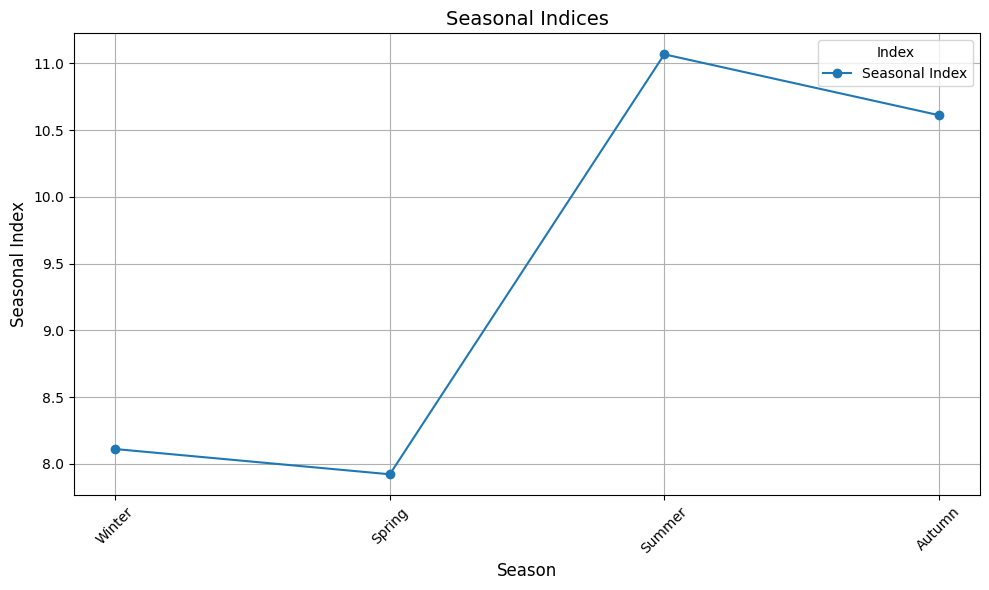

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(seasonal_indices_df.index, seasonal_indices_df['Seasonal Index'], marker='o', label='Seasonal Index')

plt.title('Seasonal Indices', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Seasonal Index', fontsize=12)
plt.legend(title='Index', fontsize=10)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

График показывает изменение сезонных индексов для каждого из четырёх сезонов (зима, весна, лето, осень), рассчитанных на основе объединённых данных за все годы.

- **Зима**: Характеризуется относительно низкими значениями сезонных индексов.
- **Весна**: Демонстрирует небольшое увеличение по сравнению с зимой, отражая умеренное сезонное влияние.
- **Лето**: Показывает самые высокие значения сезонных индексов среди всех сезонов, что говорит о значительном влиянии данного периода на данные.
- **Осень**: Находится на уровне чуть ниже лета, показывая стабильные, но менее выраженные сезонные колебания.

График иллюстрирует общий тренд сезонных колебаний: наиболее высокие индексы приходятся на лето, а минимальные значения наблюдаются зимой.

# Выводы
Проведённый анализ температуры поверхности океана за 2014–2016 годы позволил выявить важные закономерности и подтвердить корректность данных. Линейный тренд показал общий рост температуры с течением времени, что подтверждается значимостью коэффициента корреляции.

Уравнение временного ряда в аналитической форме имеет вид:

- y(t) = T(t) + S(t)

- T(t) = 7.98 + 0.08t

- S(t) = 0.16 * cos(2π * 0.03 * t - 1.04) + 0.03 * cos(2π * 0.06 * t + -0.07) + 1.09 * cos(2π * 0.08 * t + 2.42)

- y(t) = (7.98 + 0.08t) + [0.16 * cos(2π * 0.03 * t - 1.04) + 0.03 * cos(2π * 0.06 * t + -0.07) + 1.09 * cos(2π * 0.08 * t + 2.42)]

Автокорреляционный анализ выявил значимую зависимость на малых лагах, что свидетельствует о наличии связи между соседними наблюдениями. На больших лагах автокорреляция становится незначимой, что указывает на постепенное затухание взаимосвязей.

Анализ выбросов показал, что данные не содержат аномалий, подтверждая их корректность и готовность для дальнейшего анализа. Это исключает необходимость дополнительной обработки и позволяет с уверенностью использовать данные для построения моделей и прогнозов.

В заключение, проведённый анализ выявил общую тенденцию к увеличению температуры, при этом данные характеризуются элементами сезонности и слабой цикличности. Линейный подход является упрощённой моделью, и для более точного анализа рекомендуется учитывать нелинейные и сезонные составляющие. Общая структура данных позволяет сделать выводы о долгосрочных изменениях температуры, что может быть полезно для дальнейшего изучения климатических процессов.






